In [3]:
from prio_first import schedule_rules
from find_next_slot import find_r_slot

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_link_schedule(rules, bandwidth, reservations, results):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    max_time = 0
    if reservations:
        max_time = max(max_time, max(end for _, end, _ in reservations))
    if results:
        max_time = max(max_time, max(end for _, _, end, _ in results))
    max_time = max(max_time, 20)  # Minimum time range
    
    link_rect = patches.Rectangle((0, 0), max_time, bandwidth, 
                                linewidth=2, edgecolor='black', 
                                facecolor='lightgray', alpha=0.3)
    ax.add_patch(link_rect)
    
    for start_time, end_time, reserved_bw in reservations:
        reservation_rect = patches.Rectangle((start_time, 0), end_time - start_time, reserved_bw,
                                           linewidth=1, edgecolor='darkred', 
                                           facecolor='red', alpha=0.7)
        ax.add_patch(reservation_rect)
        
        # Add reservation label
        ax.text(start_time + (end_time - start_time)/2, reserved_bw/2, 
               f'Reserved\n{reserved_bw} bw', 
               ha='center', va='center', fontsize=8, color='white', weight='bold')
    
    y_offset = 0
    
    for i, (rule_idx, start_time, end_time, allocated_bw) in enumerate(results):
        size, priority = rules[rule_idx]
        color = 'blue'
        
        # Find the y position (stack rules vertically)
        y_pos = sum(res_bw for s, e, res_bw in reservations if s <= start_time < e)
        y_pos += y_offset
        
        rule_rect = patches.Rectangle((start_time, y_pos), end_time - start_time, allocated_bw,
                                        linewidth=1, edgecolor='darkblue', 
                                        facecolor=color, alpha=0.7)
        ax.add_patch(rule_rect)
        
        # Add rule label
        label = f'T{rule_idx}\nSize: {size}\nPrio: {priority}\nBW: {allocated_bw:.1f}'
        ax.text(start_time + (end_time - start_time)/2, y_pos + allocated_bw/2, 
               label, ha='center', va='center', fontsize=8, color='white', weight='bold')
        
        y_offset += allocated_bw
    
    ax.set_xlim(0, max_time)
    ax.set_ylim(0, bandwidth)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Bandwidth', fontsize=12)
    ax.set_title('Link Schedule Visualization', fontsize=14, weight='bold')
    ax.grid(True, alpha=0.3)
    
    red_patch = patches.Patch(color='red', alpha=0.7, label='Reservations')
    blue_patch = patches.Patch(color='blue', alpha=0.7, label='Scheduled Rules')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [21]:
# rule: (size, priority)
rules=[(200, 4), (100, 2), (500, 1)]
bandwidth=400
reservations=[(10, 13, 50), (15, 30, 75)]

Scheduled rules:
rule 0: time 0.00-1.00, bandwidth 200.0
rule 1: time 0.00-1.00, bandwidth 100.0
rule 2: time 0.00-5.00, bandwidth 100.0


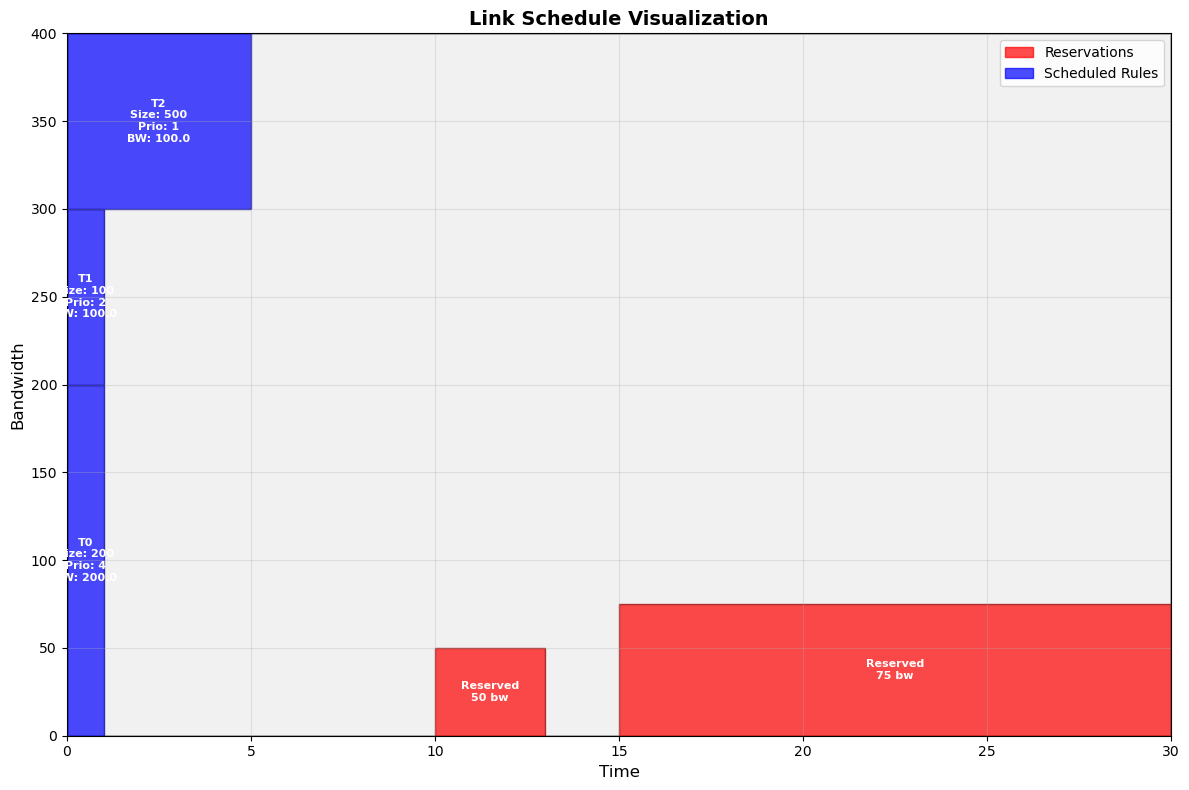

In [22]:
results = schedule_rules(rules, bandwidth, reservations)

print("Scheduled rules:")
for result in results:
    print(f"rule {result[0]}: time {result[1]:.2f}-{result[2]:.2f}, bandwidth {result[3]:.1f}")

visualize_link_schedule(rules, bandwidth, reservations, results)